In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import sys
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from help_functions import create_model, get_top_classes

### Select the training configuration

In [2]:
# ================== HYPER-PARAMETERS ==================
# config: nr_classes, labels, class_weights, basemodel, image_dimension, results_and_checkpoints_folder, data_folder
i = 6
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]
old_stdout = sys.stdout
log_file = open(config['results_and_checkpoints_folder'] + '/log_eval.txt', 'w')
sys.stdout = log_file

In [3]:
config

{'nr_classes': 20,
 'number_trainable_layers': 339,
 'class_weights': False,
 'augment': False,
 'basemodel': 'EfficientNetB2',
 'image_dimension': 64,
 'results_and_checkpoints_folder': 'thesis_experiments/6_339layers_algo_20classes_EfficientNetB2',
 'data_folder': 'data/split_dataframes_heuristic_labels_20220914'}

Load test set

In [4]:
# ====================== LOAD TEST SET =================
test_df = pd.read_json(config['data_folder'] + '/test_df.json.bz2', compression='bz2')
train_df = pd.read_json(config['data_folder'] + '/train_df.json.bz2', compression='bz2')
top_classes = get_top_classes(config['nr_classes'], train_df) # OBS: are they always the same as top classes of train_df? In the 10-case yes.
# Only keep rows which have either of the top classes
ids_x_labels = test_df.labels.apply(lambda classes_list: any([True for a_class in top_classes if a_class in classes_list]))
test_set_x_labels = test_df[ids_x_labels]
test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
test_df = test_set_x_labels.copy()

datagen = ImageDataGenerator() 
test = datagen.flow_from_dataframe(
        dataframe=test_df, 
        directory='/scratch/WIT_Dataset/images',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=(config['image_dimension'], config['image_dimension']),
        shuffle=False
        )

N_LABELS = len(test.class_indices)
# ======================================================

<ipython-input-4-7bf20e9629be>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Create model and load latest weights

In [5]:
# ============== CREATE MODEL, LOAD WEIGHTS ============
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def create_model(name):
    if name == 'EfficientNetB0':
        efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=config['nr_classes'],
                                           input_shape=(64, 64, 3))
    elif name == 'EfficientNetB1':
        efficient_net = EfficientNetB1(include_top=False, weights='imagenet', classes=config['nr_classes'],
                                           input_shape=(config['image_dimension'], config['image_dimension'], 3))
    elif name == 'EfficientNetB2':
        efficient_net = EfficientNetB2(include_top=False, weights='imagenet', classes=config['nr_classes'],
                                           input_shape=(config['image_dimension'], config['image_dimension'], 3))

    efficient_net.trainable=False

    model = Sequential([
        efficient_net,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(config['nr_classes'], activation='sigmoid')
    ])

    # model.compile(optimizer=tf.keras.optimizers.Adam(),
    #               loss='binary_crossentropy',
    #               metrics=['accuracy', 'categorical_accuracy'])

    # model.summary()
    return model
model = create_model(name=config['basemodel'])

latest = tf.train.latest_checkpoint(config['results_and_checkpoints_folder'])
print(latest)
model.load_weights(latest)
# ======================================================

Predict on test set

In [6]:
# =============== PREDICT ON TEST SET ==================
from sklearn.metrics import classification_report

predictions = model.predict(test, verbose=2)
threshold = 0.5
y_pred = 1 * (predictions > threshold)
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1
# ======================================================

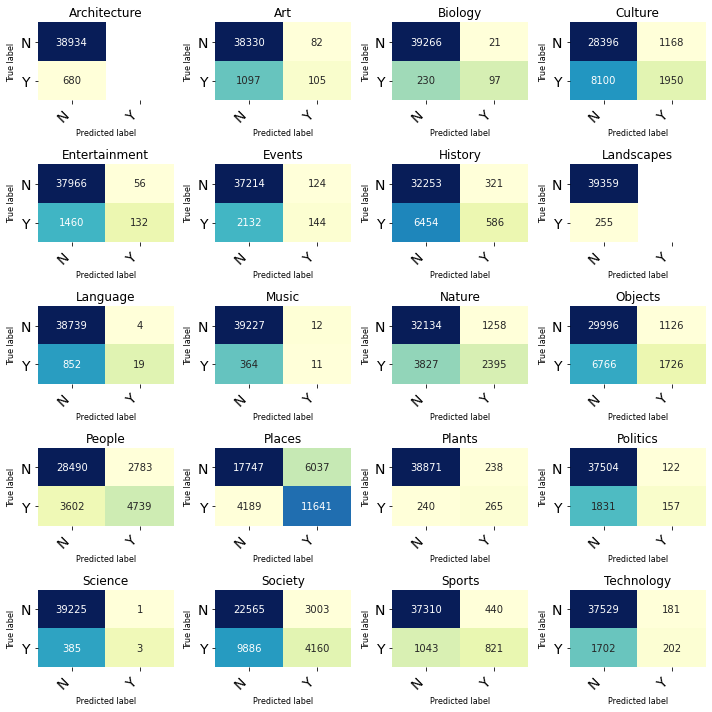

In [7]:
# ============== CONFUSION MATRICES ===================
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    # From https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap='YlGnBu', norm=LogNorm())
    except ValueError:
        raise ValueError('Confusion matrix values must be integers.')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label', fontsize=8)
    axes.set_xlabel('Predicted label', fontsize=8)
    axes.set_title(class_label)

fig, ax = plt.subplots(5, 4, figsize=(10, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, list(test.class_indices.keys())):
    print_confusion_matrix(cfs_matrix, axes, label, ['N', 'Y'])
    
fig.tight_layout()
plt.savefig(config['results_and_checkpoints_folder'] + '/confusion_matrix.png')
                                                     
# Extra:
print(f'\nMean number of label assignments per image in ground-truth: {np.sum(y_true) / y_true.shape[0]:.4f}')
print(f'Mean number of label assignments per image in predictions: {np.sum(y_pred) / y_pred.shape[0]:.4f}\n')
                                                     
# ======================================================

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


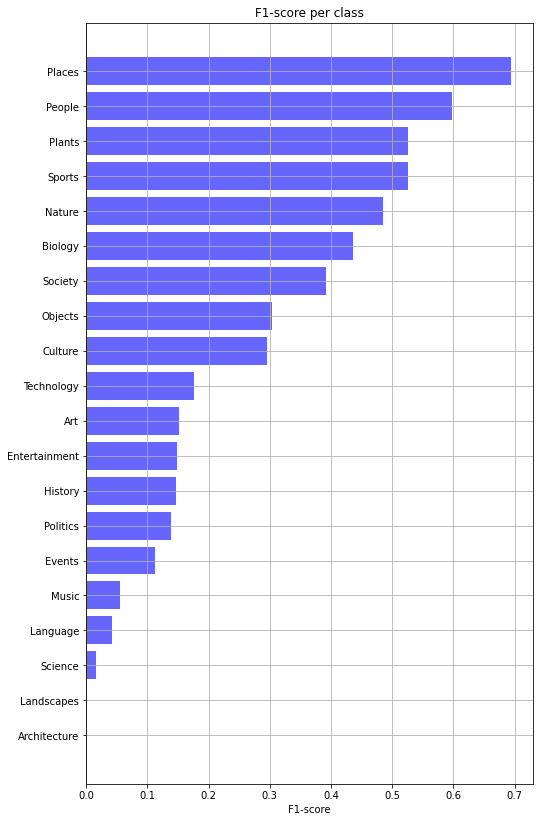

In [8]:
# ================== GET METRICS ======================

metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_LABELS), [None, None, None, None]))
print(metrics_df)

# F1-score
sorted_indices_f1score = np.argsort(metrics_df['f1-score'][0:N_LABELS])
sorted_f1score_per_class = metrics_df['f1-score'][0:N_LABELS][sorted_indices_f1score]

print(f'\nUnweighted avg. F1-score of all classes: {np.sum(sorted_f1score_per_class) / len(sorted_f1score_per_class)}')
print(f'Unweighted avg. F1-score of top 5 classes: {np.sum(sorted_f1score_per_class[-4:]) / 5}')
print(f'Unweighted avg. F1-score of the rest: {np.sum(sorted_f1score_per_class[0:-4]) / (len(sorted_f1score_per_class) - 5)}\n')

_ = plt.figure(figsize=(8, 14))
                
_ = plt.title('F1-score per class')
_ = plt.barh(range(y_true.shape[1]), sorted_f1score_per_class, color='blue', alpha=0.6)
_ = plt.yticks(ticks=range(N_LABELS), labels=np.array(list(test.class_indices.keys()))[sorted_indices_f1score])
_ = plt.xlabel('F1-score')
_ = plt.grid(True)

plt.savefig(config['results_and_checkpoints_folder'] + '/f1_scores.png')

# Per-class accuracy
print('\n------- Per-class accuracy: --------\n')
from collections import Counter
total = Counter()
correct = Counter()
for i in range(len(test.classes)):
    true_y = test.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(predictions[i] >= 0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

name_id_map = test.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k
            
for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], round(correct[k]/total[k], 3)))
# ======================================================

#### ROC curve for each class

On micro and macro averaging: Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

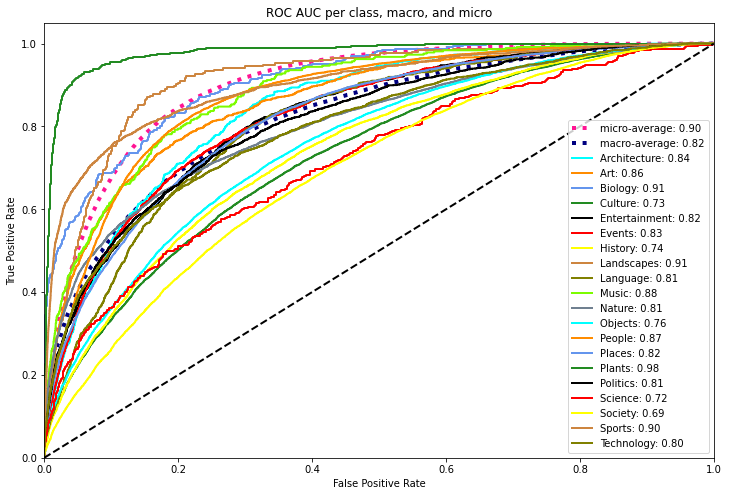

In [9]:
# ================== ROC CURVE PER CLASS ===============
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_LABELS):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_LABELS)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_LABELS):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= N_LABELS

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.figure(figsize=(12, 8))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average: { roc_auc['micro'] :0.2f}",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average: { roc_auc['macro'] :0.2f}",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "black", "red", "yellow", "peru", "olive", "lawngreen", "slategray"])
for i, color in zip(range(N_LABELS), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label=f"{list(name_id_map.keys())[i]}: {roc_auc[i]:0.2f}"
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC per class, macro, and micro")
plt.legend(loc="lower right")
plt.savefig(config['results_and_checkpoints_folder'] + '/roc_curves.png')
# ======================================================

In [10]:
sys.stdout = old_stdout

log_file.close()

In [14]:
# Inspiration for visualization: https://www.kaggle.com/code/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb/notebook
from sklearn.metrics import f1_score


width, height = config['image_dimension'], config['image_dimension']
target_size = (height, width)
BATCH_SIZE = 512

train_generator = datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory='/scratch/WIT_Dataset/images/', 
        seed=7,
        subset='training',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=BATCH_SIZE,
        target_size=target_size)

CLASS_LABELS = list(train_generator.class_indices.keys())

train_predictions = model.predict(train_generator)

y_true_val = np.zeros(train_predictions.shape)
for row_idx, row in enumerate(train_predictions.classes):
    for idx in row:
        y_true_val[row_idx, idx] = 1

def plot_probs_and_best_threshold(y_true, probs):
    def to_label(probs, threshold):
        return (probs >= threshold) * 1

    thresholds = np.linspace(start=0, stop=1, num=101)
    
    best_thresholds = np.zeros((len(CLASS_LABELS, )))

    # F1-scores per threshold
    fig, axs = plt.subplots(5, 4, figsize=(12, 12))
    fig.tight_layout(h_pad=3.0, w_pad=3.0)
    for label_idx, ax in zip(range(len(CLASS_LABELS)), axs.flatten()):
        f1_scores = [f1_score(y_true=y_true[:, label_idx], y_pred=to_label(probs[:, label_idx], t)) for t in thresholds]
        best_thresholds[label_idx] = thresholds[np.argmax(f1_scores)]
        ax.axvline(x=best_thresholds[label_idx], color='k', linestyle='--')
        ax.plot(thresholds, f1_scores)
        ax.set_title(CLASS_LABELS[label_idx])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-score')

    # Prediction probabilities for ground-truth TRUE and FALSE
    fig, axs = plt.subplots(5, 4, figsize=(12, 12))
    fig.tight_layout(h_pad=3.0, w_pad=3.0)
    bins = np.linspace(0, 1, 75)
    for label_idx, ax in zip(range(len(CLASS_LABELS)), axs.flatten()):
        ax.hist(probs[y_true[:, label_idx] == 0][:, label_idx], bins, alpha=0.5, label='false', log=True)
        ax.hist(probs[y_true[:, label_idx] == 1][:, label_idx], bins, alpha=0.5, label='true', log=True)
        ax.axvline(x=best_thresholds[label_idx], color='k', linestyle='--')
        ax.legend(loc='upper right')
        ax.set_title(CLASS_LABELS[label_idx])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Count')
plot_probs_and_best_threshold(y_true=y_true_val, probs=train_predictions)


KeyboardInterrupt: 